# Creating Analysis Dataset

In [1]:
import pymysql
import pandas as pd
import numpy as np

In [2]:
conn = pymysql.connect(
    user=USER,
    password=PASS,
    host=HOST,
    db='financial'
)

In [3]:
cur = conn.cursor()

In [4]:
# Create detail of each accounts credit and debit over the period of years the account
# has been open, along with the status of any loans they've taken out. This will
# be the output of any classification

cur.execute("""SELECT 
   ID1, 
   CREDIT, 
   DEBIT, 
   CREDIT-DEBIT net, 
   CASE WHEN loan_status is NULL THEN  'E'ELSE loan_status END loan_status 
FROM  
   (SELECT 
       account_id ID1, 
       SUM(amount) CREDIT 
   FROM 
       trans  
   WHERE 
       type LIKE 'PRIJEM' 
   GROUP BY ID1) a 
LEFT OUTER JOIN 
   (SELECT 
       account_id ID2, 
       SUM(amount) DEBIT 
   FROM 
       trans  
   WHERE 
       type LIKE 'VYDAJ' 
   GROUP BY ID2) b  
ON 
   a.ID1 = b.ID2 
LEFT OUTER JOIN 
   (SELECT 
       account_id ID3, 
       status loan_status 
   FROM 
       loan 
   GROUP BY 
       ID3) c 
ON a.ID1 = c.ID3;
""")

4500

In [5]:
df1 = pd.DataFrame(cur.fetchall(), columns=['account_id', 'credit', 'debit', 'net', 'loan_status'])

In [6]:
df1.set_index('account_id', inplace=True)

In [7]:
loan_status_map = {
    'A':0,
    'B':1,
    'C':2,
    'D':3,
    'E':4
}

df1['loan_status'] = df1['loan_status'].map(loan_status_map)

In [8]:
cur.execute("""SELECT 
   account_id, 
   SUM(amount) OVER(PARTITION BY account_id) account_spend,  
   SUM(amount) OVER(partition by account_id, k_symbol) k_spend, 
   SUM(amount) OVER(PARTITION BY account_id, k_symbol)/SUM(amount) OVER(PARTITION BY account_id)  k_proportion,  
   CASE WHEN k_symbol LIKE '' THEN 'OTHER' ELSE k_symbol END transaction_type
FROM 
   `order`;
""")

6471

In [9]:
df2 = pd.DataFrame(cur.fetchall(), columns=['account_id', 'account_spend', 'k_spend', 'k_proportion', 'transaction_type'])

In [10]:
df2.head()

,account_id,account_spend,k_spend,k_proportion,transaction_type
0,1,2452.0,2452.0,1.00000,SIPO
1,2,10638.7,7266.0,0.68298,SIPO
2,2,10638.7,3372.7,0.31702,UVER
3,3,5001.0,327.0,0.06539,OTHER
4,3,5001.0,3539.0,0.70766,POJISTNE


In [11]:
df2 = pd.pivot_table(df2, values='k_proportion', index='account_id', columns='transaction_type', aggfunc=max).fillna(0)

In [12]:
df2

transaction_type,LEASING,OTHER,POJISTNE,SIPO,UVER
account_id,,,,,
1,0,0,0,1.00000,0
2,0,0,0,0.68298,0.31702
3,0,0.06539,0.70766,0.22695,0
4,0,0,0,1.00000,0
5,0,0,0,1.00000,0
...,...,...,...,...,...
11328,0,0,0,0,1.00000
11333,1.00000,0,0,0,0
11349,0,0,0,0.60870,0.39130


In [13]:
cur.execute("""
SELECT account_id, operation, AVG(num) FROM 
(SELECT account_id, EXTRACT(YEAR FROM date) Y, EXTRACT(MONTH FROM date) M,  COUNT(*) num, SUM(amount), operation from trans 
GROUP BY account_id, Y, M, operation) sub 
GROUP BY account_id, operation;
""")

19468

In [14]:
df3 = pd.DataFrame(cur.fetchall(), columns=['account_id', 'trans_operation', 'avg_per_trans_type'])

In [15]:
df3.set_index('account_id', inplace=True)

In [16]:
df3 = pd.pivot_table(df3, values='avg_per_trans_type', index='account_id', columns='trans_operation', aggfunc=max).fillna(0)

In [17]:
df3.fillna(0, inplace=True)

In [18]:
df3

trans_operation,PREVOD NA UCET,PREVOD Z UCTU,VKLAD,VYBER,VYBER KARTOU
account_id,,,,,
1,1.0000,1.0000,1.0000,2.2558,0
2,1.3692,1.0000,1.0000,3.4348,0
3,3.0000,0,1.5556,2.0000,0
4,1.9667,1.0000,1.0000,2.0667,0
5,1.0000,1.0000,1.0000,2.3333,0
...,...,...,...,...,...
11333,0,0,1.6596,3.3636,0
11349,1.9744,1.0000,1.0000,3.1628,0
11359,2.2609,1.0000,1.0000,2.9020,1.8333


In [19]:
cur.execute("""
SELECT 
   account_id, 
   COUNT(*) sanction_count, 
   SUM(amount) sanction_amount 
FROM 
   trans 
WHERE 
   k_symbol 
LIKE 
   'SANKC. UROK' 
GROUP BY 
   account_id;
""")

264

In [20]:
df4 = pd.DataFrame(cur.fetchall(), columns=['account_id', 'sanction_count', 'sanction_amount']).set_index('account_id')

In [21]:
df4

,sanction_count,sanction_amount
account_id,,
19,8,58
37,1,0
58,2,27
91,4,66
102,2,2
...,...,...
11295,2,4
11320,8,109
11325,10,176


In [22]:
cur.execute("""
SELECT  
   l.account_id,  
   l.amount loan_amount, 
   l.duration loan_duration, 
   l.payments loan_payments, 
   a.district_id,  
   d.A4 population,  
   d.A11 district_salary,  
   d.A12 unemp_95,  
   d.A13 unemp_96,  
   d.A15/d.A4 crime_rate_95,  
   d.A16/d.A4 crime_rate_96  
FROM  
   loan l,  
   account a,  
   district d  
WHERE  
   l.account_id = a.account_id  
AND  
   a.district_id = d.district_id
""")

682

In [23]:
df5 = pd.DataFrame(cur.fetchall(), 
                   columns=['account_id', 'loan_amount', 'loan_duration', 'loan_payments', 'district_id', 'population', 'district_salary',
                  'unemp_95', 'unemp_96', 'crime_rate_95', 'crime_rate_96']).set_index('account_id')

In [24]:
df5.drop('district_id', axis=1, inplace=True)
df5.head()

,loan_amount,loan_duration,loan_payments,population,district_salary,unemp_95,unemp_96,crime_rate_95,crime_rate_96
account_id,,,,,,,,,
2,80952,24,3373.00,1204953,12541,0.2,0.43,0.0711,0.0822
19,30276,12,2523.00,103347,9104,1.5,2.07,0.0222,0.0228
25,30276,12,2523.00,228848,9893,4.0,4.72,0.0246,0.0257
37,318480,60,5308.00,70646,8547,2.6,3.64,0.0221,0.0218
38,110736,48,2307.00,51428,8402,3.1,3.98,0.0194,0.0214


In [25]:
cur.execute("""
SELECT 
      c.client_id client_id, 
      d.account_id, 
      d.type, 
      c.gender gender, 
      c.birth_date birthdate, 
      c.district_id district_id, 
      l.loan_id, 
      l.date loan_date, 
      EXTRACT(YEAR from l.date) - EXTRACT(YEAR from c.birth_date) age_at_loan, 
      CASE WHEN ca.type LIKE 'junior' THEN 0 WHEN ca.type LIKE 'classic' THEN 1 WHEN ca.type LIKE 'gold' THEN 2 ELSE 3 END card_type
   FROM 
      client c 
   INNER JOIN 
      disp d 
   ON 
      c.client_id = d.client_id 
   INNER JOIN 
      loan l 
   ON 
      d.account_id = l.account_id 
   LEFT OUTER JOIN
      card ca
   ON
      ca.disp_id = d.disp_id
   WHERE 
      d.type = 'OWNER'
""")

682

In [26]:
df6 = pd.DataFrame(cur.fetchall(), columns=['client_id', 'account_id', 'disp_type', 'gender', 'birthdate', 'district_id', 'loan_id', 'loan_date', 'age_at_loan', 'card_type']).set_index('account_id')

In [27]:
df6.head()

,client_id,disp_type,gender,birthdate,district_id,loan_id,loan_date,age_at_loan,card_type
account_id,,,,,,,,,
2,2,OWNER,M,1945-02-04,1,4959,1994-01-05,49,3
19,25,OWNER,F,1939-04-23,21,4961,1996-04-29,57,3
25,31,OWNER,M,1962-02-09,68,4962,1997-12-08,35,3
37,45,OWNER,M,1952-08-26,20,4967,1998-10-14,46,3
38,46,OWNER,F,1940-01-30,19,4968,1998-04-19,58,3


In [28]:
df = df1.join(df2, how='inner').join(df3, how='inner').join(df4, how='left').join(df5, how='inner').join(df6.drop('district_id', axis=1))

In [29]:
# Creating 1,2 and 3 month windows prior to loan date
lag_dict = {}

for i in [1,2,3]:

    cur.execute("SELECT t.account_id, SUM(t.amount * CASE WHEN t.type LIKE 'PRIJEM' THEN 1 WHEN t.type LIKE 'VYDAJ' OR t.type LIKE 'VYBER' THEN -1 END) net FROM trans t, loan l WHERE t.account_id = l.account_id AND t.date BETWEEN DATE_SUB(l.date, INTERVAL %s MONTH) AND l.date GROUP BY t.account_id;", (i,))
    
    lag_dict[i] = cur.fetchall()
    if i == 1:
        temp_df = pd.DataFrame(lag_dict[i], columns=['account_id', f'month_{i}_lag'])
        temp_df.set_index('account_id', inplace=True)
    if i > 1:
        temp_df2 =  pd.DataFrame(lag_dict[i], columns=['account_id', f'month_{i}_lag'])
        temp_df2.set_index('account_id', inplace=True)
        temp_df = temp_df.join(temp_df2)
        

In [30]:
df = df.join(temp_df)

In [31]:
df.drop(['client_id', 'disp_type', 'birthdate', 'loan_id', 'loan_date'], axis=1, inplace=True)

In [32]:
df['gender'] = df['gender'].map({'M':0,
                                'F':1})

In [33]:
for col in df.columns:
    print(col, '-----', df[col].dtype)

credit ----- object
debit ----- object
net ----- object
loan_status ----- int64
LEASING ----- object
OTHER ----- object
POJISTNE ----- object
SIPO ----- object
UVER ----- object
PREVOD NA UCET ----- object
PREVOD Z UCTU ----- object
VKLAD ----- object
VYBER ----- object
VYBER KARTOU ----- object
sanction_count ----- float64
sanction_amount ----- object
loan_amount ----- int64
loan_duration ----- int64
loan_payments ----- object
population ----- int64
district_salary ----- int64
unemp_95 ----- object
unemp_96 ----- object
crime_rate_95 ----- object
crime_rate_96 ----- object
gender ----- int64
age_at_loan ----- int64
card_type ----- int64
month_1_lag ----- object
month_2_lag ----- object
month_3_lag ----- object


In [34]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [35]:
for col in df.columns:
    print(col, '-----', df[col].dtype)

credit ----- float64
debit ----- float64
net ----- float64
loan_status ----- int64
LEASING ----- int64
OTHER ----- float64
POJISTNE ----- float64
SIPO ----- float64
UVER ----- float64
PREVOD NA UCET ----- float64
PREVOD Z UCTU ----- float64
VKLAD ----- float64
VYBER ----- float64
VYBER KARTOU ----- float64
sanction_count ----- float64
sanction_amount ----- float64
loan_amount ----- int64
loan_duration ----- int64
loan_payments ----- float64
population ----- int64
district_salary ----- int64
unemp_95 ----- float64
unemp_96 ----- float64
crime_rate_95 ----- float64
crime_rate_96 ----- float64
gender ----- int64
age_at_loan ----- int64
card_type ----- int64
month_1_lag ----- float64
month_2_lag ----- float64
month_3_lag ----- float64


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/grant/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
df['loan_status'].value_counts()

2    403
0    203
3     45
1     31
Name: loan_status, dtype: int64

In [38]:
df['default'] = df['loan_status'].map({0:0,
                                      1:1,
                                      2:0,
                                      3:1})

In [39]:
df['default'].value_counts()

0    606
1     76
Name: default, dtype: int64

In [40]:
df.fillna(0, inplace=True)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [42]:
X = df[df.columns[~df.columns.isin(['loan_status', 'default'])]]
y = df['default']

In [43]:
clf = RandomForestClassifier(max_depth=5)
X_train, x_test, y_train, y_test = train_test_split(X,y)

In [44]:
clf = clf.fit(X_train,y_train)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [45]:
from sklearn import tree

In [46]:
X_train['VYBER']

account_id
8159     2.7778
6902     2.6000
4995     2.9608
825      2.9063
9633     3.9412
          ...  
7733     4.2414
4715     2.8462
10884    2.8889
3608     2.8077
4268     2.9048
Name: VYBER, Length: 511, dtype: float64

0 --- credit
1 --- debit
2 --- net
3 --- LEASING
4 --- OTHER
5 --- POJISTNE
6 --- SIPO
7 --- UVER
8 --- PREVOD NA UCET
9 --- PREVOD Z UCTU
10 --- VKLAD
11 --- VYBER
12 --- VYBER KARTOU
13 --- sanction_count
14 --- sanction_amount
15 --- loan_amount
16 --- loan_duration
17 --- loan_payments
18 --- population
19 --- district_salary
20 --- unemp_95
21 --- unemp_96
22 --- crime_rate_95
23 --- crime_rate_96
24 --- gender
25 --- age_at_loan
26 --- card_type
27 --- month_1_lag
28 --- month_2_lag
29 --- month_3_lag


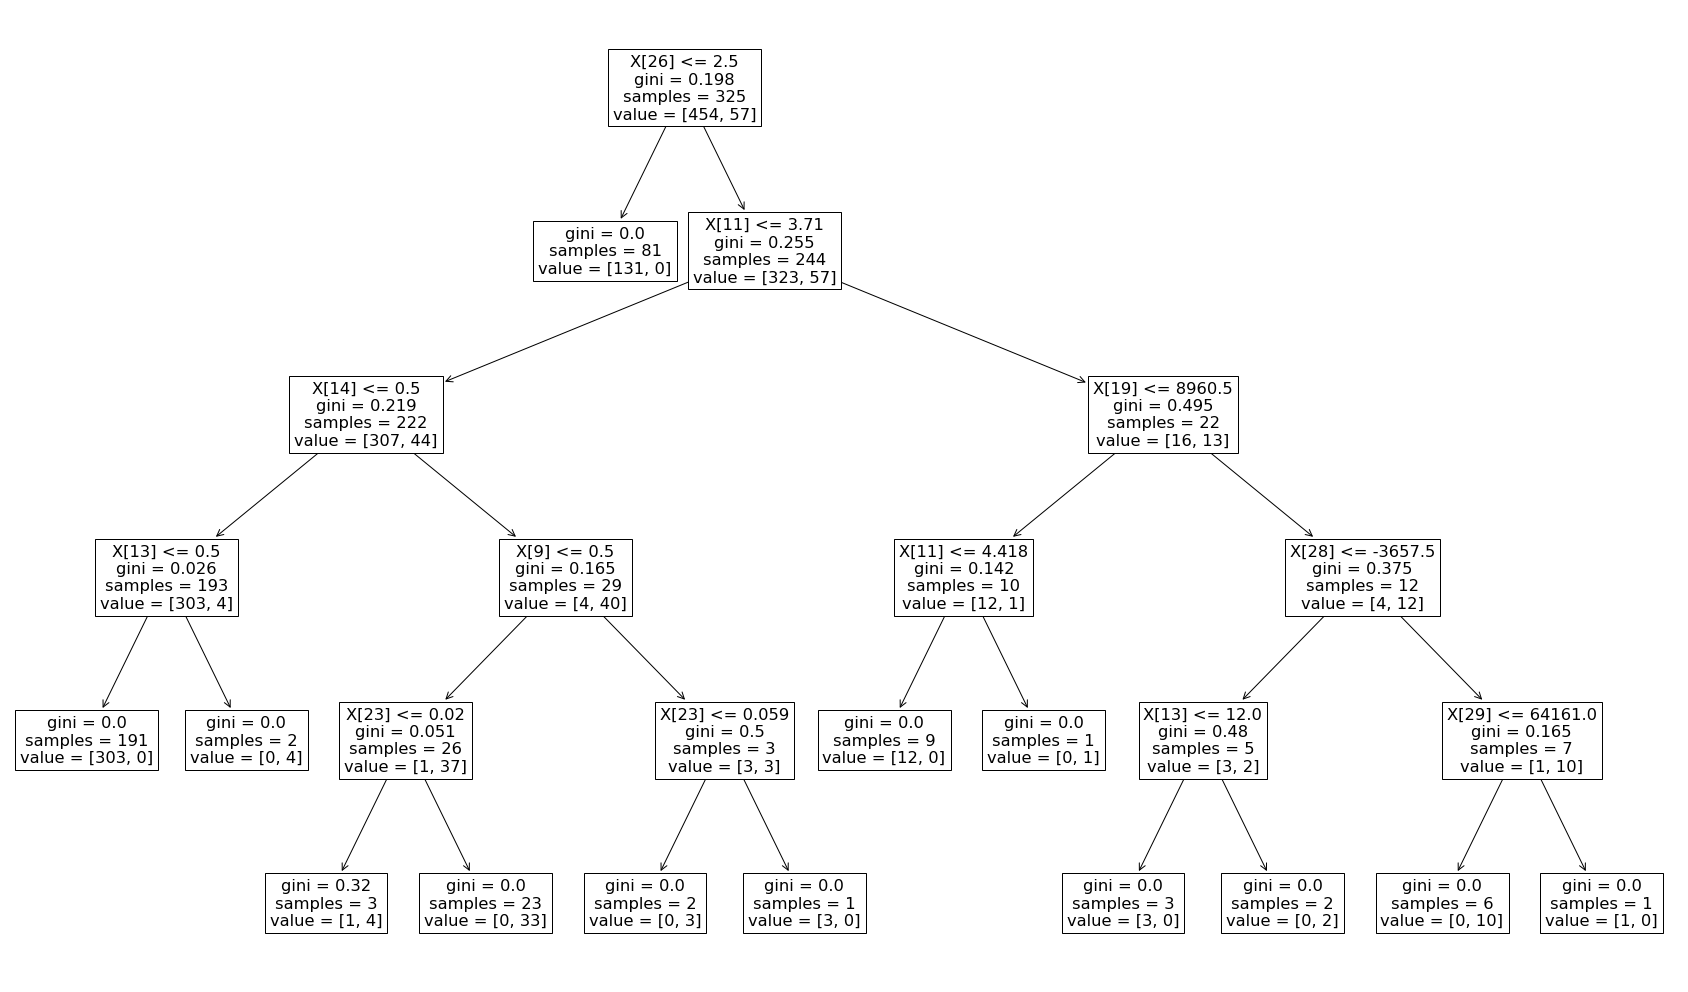

In [47]:
fig,ax = plt.subplots(figsize=(30,18))
tree.plot_tree(clf.estimators_[1], ax=ax)
for num,col in enumerate(X_train.columns):
    print(num, '---', col)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text xticklabel objects>)

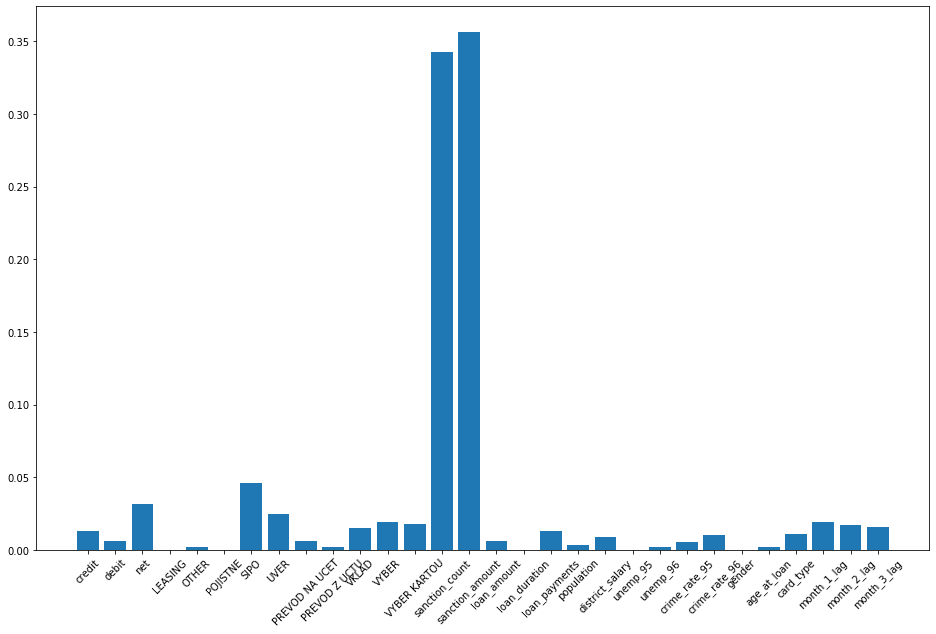

In [48]:
plt.figure(figsize=(16,10))
plt.bar(X.columns, clf.feature_importances_)
plt.xticks(rotation=45)

In [49]:
y_pred = clf.predict(x_test)
y_true = y_test.values

In [50]:
confusion = np.zeros([2,2])

In [51]:
for i in range(y_pred.shape[0]):
    if y_pred[i] == 0 and y_true[i] == 0:
        confusion[0,0] += 1
    elif y_pred[i] == 1 and y_true[i] == 0:
        confusion[0,1] += 1
    elif y_pred[i] == 0 and y_true[i] == 1:
        confusion[1,0] += 1
    elif y_pred[i] == 1 and y_true[i] == 1:
        confusion[1,1] += 1
    

Text(33.0, 0.5, 'Actual')

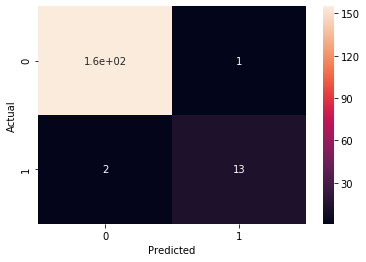

In [52]:
sns.heatmap(confusion, annot=confusion)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [54]:
print(confusion_matrix(y_true, y_pred))
print(f'True Positive = {22/25*100}')
print(f'True Negative = {144/146*100}')

[[155   1]
 [  2  13]]
True Positive = 88.0
True Negative = 98.63013698630137


In [55]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       156
           1       0.93      0.87      0.90        15

    accuracy                           0.98       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.98      0.98      0.98       171



In [56]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=3)

In [58]:
pca_X = (X - X.mean())/(X.std()+0.000001)

In [63]:
pca.fit_transform(pca_X)

array([[ 4.80411529, -0.99994727, -1.06157003],
       [-0.78373833,  0.34575266,  1.85822488],
       [-0.96682471, -0.28620664, -2.90632088],
       ...,
       [ 4.87837567,  0.02189927, -0.2708558 ],
       [-1.60291788,  0.81155114, -2.18674135],
       [-2.19043942, -1.4047992 , -0.23905954]])

In [96]:
pd.DataFrame(pca.components_, columns=X_train.columns).T.sort_values(0)

,0,1,2
unemp_96,-3.071706e-01,8.401648e-02,-9.070744e-02
unemp_95,-2.885163e-01,6.293018e-02,-1.091326e-01
card_type,-6.520484e-02,-1.213292e-01,1.833469e-01
age_at_loan,-6.163110e-02,-6.301897e-02,1.506546e-03
SIPO,-4.716162e-02,-2.468338e-01,-2.602934e-01
loan_duration,-4.484951e-02,-4.327257e-02,1.882901e-01
PREVOD NA UCET,-4.428757e-02,-2.493158e-01,-2.320356e-01
PREVOD Z UCTU,-1.504152e-02,4.414658e-02,-2.708604e-02
OTHER,-1.414581e-02,-1.475719e-01,-1.719662e-01
POJISTNE,-1.405359e-03,-1.258528e-01,-1.026916e-01


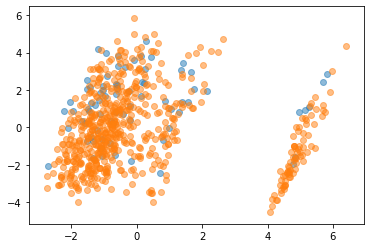

In [97]:
default_mask = y == 1
plt.scatter(pca_trans[:,0][default_mask], pca_trans[:,1][default_mask], alpha=0.5)
plt.scatter(pca_trans[:,0][~default_mask], pca_trans[:,1][~default_mask], alpha=0.5)

In [98]:
from sklearn.cluster import KMeans

In [103]:
km = KMeans(n_clusters=3)

In [104]:
km.fit(pca_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

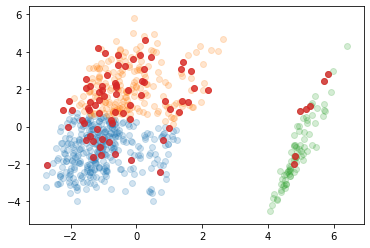

In [106]:
plt.scatter(pca_trans[:,0][km.labels_ == 0], pca_trans[:,1][km.labels_ == 0], alpha=0.2)
plt.scatter(pca_trans[:,0][km.labels_ == 1], pca_trans[:,1][km.labels_ == 1], alpha=0.2)
plt.scatter(pca_trans[:,0][km.labels_ == 2], pca_trans[:,1][km.labels_ == 2], alpha=0.2)
plt.scatter(pca_trans[:,0][default_mask], pca_trans[:,1][default_mask], alpha=0.8)

# Defaulters appear evenly distributed across clusters

In [107]:
import xgboost as xgb

In [108]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(x_test.values, label=y_test.values)

In [109]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-auc:0.96603	train-auc:0.97938
[1]	eval-auc:0.96539	train-auc:0.98911
[2]	eval-auc:0.96496	train-auc:0.98991
[3]	eval-auc:0.96026	train-auc:0.98931
[4]	eval-auc:0.95000	train-auc:0.99772
[5]	eval-auc:0.95983	train-auc:0.99904
[6]	eval-auc:0.95192	train-auc:0.99922
[7]	eval-auc:0.96389	train-auc:0.99943
[8]	eval-auc:0.96560	train-auc:0.99971
[9]	eval-auc:0.95940	train-auc:0.99974
[10]	eval-auc:0.96239	train-auc:0.99985
[11]	eval-auc:0.96026	train-auc:0.99985
[12]	eval-auc:0.95705	train-auc:1.00000
[13]	eval-auc:0.95449	train-auc:1.00000
[14]	eval-auc:0.95150	train-auc:1.00000


In [110]:
boost_pred = np.round(bst.predict(dtest))

In [111]:
print(classification_report(y_test, boost_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       156
           1       0.93      0.87      0.90        15

    accuracy                           0.98       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.98      0.98      0.98       171

